In [50]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import BertModel, AutoModelForCausalLM

In [51]:
def get_score_linalg(Wq, Wk):

    M = Wq @ Wk.T
    SYM = .5 * (M + M.T)
    score = (np.linalg.norm(SYM, 'fro') / np.linalg.norm(M, 'fro')) ** 2

    return score

def get_score_power_sum(h, Wq, Wk):

    scores = np.zeros(h)

    M = torch.matmul(Wk.transpose(-1, -2), Wq)
    S = 0.5 * (M + M.transpose(-1, -2))

    for j in range(h):
        scores[j] = S[j].pow(2).sum() / M[j].pow(2).sum()

    return scores    

In [52]:
""" BERT models """

def getscoresBERT(d, l, h, dh, model):

    ## tranpose matrix + reshape as (embedding dim (d), # heads (h), head dim (dh))
    d_h_dh = np.zeros((l,h))
    ## not tranpose matrix + reshape as (# heads (h), head dim (dh), embedding dim (d))
    h_dh_d = np.zeros((l,h))
    
    # retrieve all BertLayer instances (the encoder in each layer)
    layers = model.encoder.layer

    for i, layer in enumerate(layers):

        
        self_attention = layer.attention.self
        Wq = self_attention.query._parameters["weight"].T.view(d, h, dh).detach().numpy()
        Wk = self_attention.key._parameters["weight"].T.view(d, h, dh).detach().numpy()

        for j in range(h):
            
            d_h_dh[i,j] = get_score_linalg(Wq[:,j,:], Wk[:,j,:])

        Wq = self_attention.query.weight.data.reshape(h, dh, d)
        Wk = self_attention.key.weight.data.view(h, dh, d)

        h_dh_d[i,:] = get_score_power_sum(h, Wq, Wk)

    return  d_h_dh, h_dh_d


In [53]:
dh = 64
l = 12
d = 768
h = d // dh

'BERT base (l = 12, d = 768, h = 12 ; 110M parameters)'
model = BertModel.from_pretrained("bert-base-uncased")
d_h_dh, h_dh_d = getscoresBERT(d, l, h, dh, model)

(0.0, 1.0)

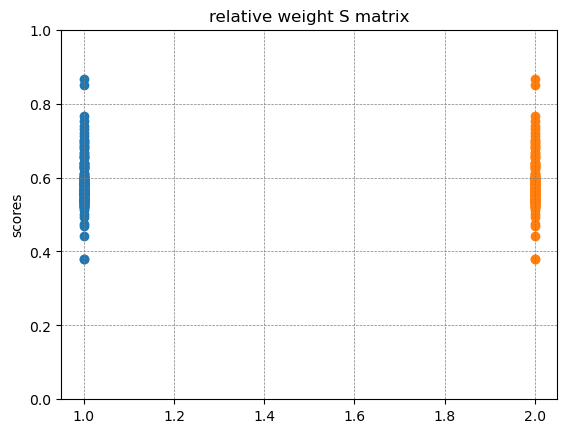

In [54]:
plt.scatter(np.ones(d_h_dh.size), d_h_dh.flatten())
plt.scatter(2*np.ones(h_dh_d.size), h_dh_d.flatten())

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight S matrix')
plt.ylabel('scores')
plt.ylim(0,1)

In [55]:
np.allclose(d_h_dh, h_dh_d)

True

In [56]:
""" Tiny GPT models """

def getscoresTinyGPT(d, l, h, dh, model):

    ## tranpose matrix + reshape as (embedding dim (d), # heads (h), head dim (dh))
    d_h_dh = np.zeros((l,h))
    ## not tranpose matrix + reshape as (# heads (h), head dim (dh), embedding dim (d))
    h_dh_d = np.zeros((l,h))
    
    # retrieve all BertLayer instances (the encoder in each layer)
    layers = model.transformer.h

    for i, layer in enumerate(layers):

        self_attention = layer.attn.attention
        Wq = self_attention.q_proj._parameters["weight"].T.view(d, h, dh).detach().numpy()
        Wk = self_attention.k_proj._parameters["weight"].T.view(d, h, dh).detach().numpy()

        for j in range(h):
            
            d_h_dh[i,j] = get_score_linalg(Wq[:,j,:], Wk[:,j,:])

        Wq = self_attention.q_proj.weight.data.reshape(h, dh, d)
        Wk = self_attention.k_proj.weight.data.view(h, dh, d)

        h_dh_d[i,:] = get_score_power_sum(h, Wq, Wk)

    return  d_h_dh, h_dh_d


In [57]:
dh = 64
l = 8
d = 512
h = d // dh

'TinyGPT 28M (l = 8, d = 512 h = 8 ; 28M parameters)'
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-28M")
d_h_dh, h_dh_d = getscoresTinyGPT(d,l,h,dh,model)

(0.0, 1.0)

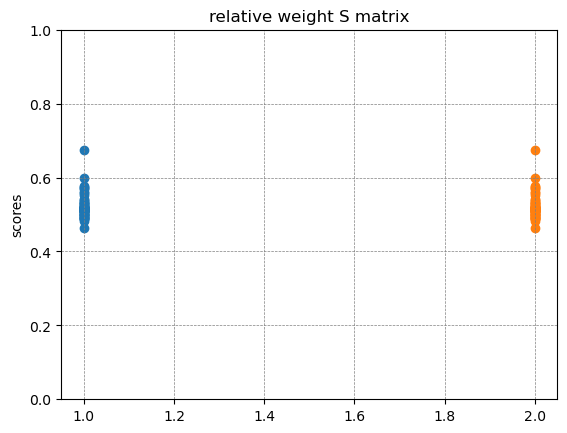

In [58]:
plt.scatter(np.ones(d_h_dh.size), d_h_dh.flatten())
plt.scatter(2*np.ones(h_dh_d.size), h_dh_d.flatten())

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight S matrix')
plt.ylabel('scores')
plt.ylim(0,1)

In [59]:
np.allclose(d_h_dh, h_dh_d)

True